In [1]:
# LSTM 有两层 LSTM 的结构

In [2]:
# 准备数据
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import time
import matplotlib.pyplot as plt

# 设置 GPU 优先
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# 加载数据
dataset = pd.read_csv("601229.csv", index_col=0)
dataset = dataset.drop(['date'], axis=1)
# print(dataset.columns)
# print(dataset.tail())
# dataset['future'] = dataset['future']
print(dataset.shape)
# print(dataset.tail())


# 将数据按照BATCH_SIZE的窗口进行滑动，每个窗口数据做一组
# # 数据转成sequence的格式，这里定义每个seq的长度
SEQ_LENGTH = 60
BATCH_SIZE = 1                                                    # 注意：BATCH_SIZE是要能够整除seq_count的
TEST_BATCH_COUNT = 1

# 把数据切换成 BATCH_SIZE 的一个个batch
rolling_data = pd.DataFrame()
for i in dataset.rolling(SEQ_LENGTH):
    if i.shape[0] == SEQ_LENGTH:
        rolling_data = rolling_data.append(i)

rolling_data = rolling_data.values.reshape(-1, SEQ_LENGTH, dataset.shape[1])                 # 数据一共是 seq_count x seq_len x (in_dim+1)

print("rolling_data shape: {}".format(rolling_data.shape))
print("seq count: {}".format(rolling_data.shape[0]))                                         # 所以一共有 seq_count 列数据，每一行的数据是123维 （包括y）
print("seq length: {}".format(SEQ_LENGTH))


total_batch_count = int(rolling_data.shape[0]/BATCH_SIZE)                                   # 把数据规划成 batch_count 个 batch

print("total batch count: {}".format(total_batch_count))
print("batch size: {}".format(BATCH_SIZE))

rolling_data = rolling_data.reshape(total_batch_count, BATCH_SIZE, SEQ_LENGTH, dataset.shape[1])  # 把数据转成 total_batch_count x BATCH_SIZE x seq_len x in_dim 格式
rolling_data = torch.tensor(rolling_data)
print("rolling_data: {}".format(rolling_data.shape))


train_batch_count = total_batch_count - TEST_BATCH_COUNT
test_batch_count = TEST_BATCH_COUNT

train = rolling_data[:train_batch_count, :, :, :]
test  = rolling_data[train_batch_count:, :, :, :]

train_x, train_y = train[:,:,:,1:], train[:,:,:,0:1]
test_x,  test_y  = test[:,:,:, 1:],  test[:,:,:,0:1]

train_x = train_x.to(device)
train_y = train_y.to(device)
test_x = test_x.to(device)
test_y = test_y.to(device)

print("train_x: {}".format(train_x.shape))
print("train_y: {}".format(train_y.shape))
print("test_x:  {}".format(test_x.shape))
print("test_y:  {}".format(test_y.shape))
print("train_batch_count: {}".format(train_batch_count))
print("test_batch_count:  {}".format(test_batch_count))

(500, 129)
rolling_data shape: (441, 60, 129)
seq count: 441
seq length: 60
total batch count: 441
batch size: 1
rolling_data: torch.Size([441, 1, 60, 129])
train_x: torch.Size([440, 1, 60, 128])
train_y: torch.Size([440, 1, 60, 1])
test_x:  torch.Size([1, 1, 60, 128])
test_y:  torch.Size([1, 1, 60, 1])
train_batch_count: 440
test_batch_count:  1


In [3]:
# 定义 LSTM 模型
np.random.seed(1027)
torch.manual_seed(1027)
torch.cuda.manual_seed(1027)
torch.backends.cudnn.deterministic = True

TIME_STEP = SEQ_LENGTH                                        # 一般这个单独设定，这里为了简单，还是直接就等于seq_len的方便。其实也就是等于最长的那个sequence length
INPUT_SIZE = dataset.shape[1]-1
HIDDEN_SIZE = 768
NUM_LAYERS = 2


class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, num_layers, output_size, dropout=0.5):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=int(hidden_layer_size/2), num_layers=num_layers, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=int(hidden_layer_size/2), hidden_size=hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.linear_1 = nn.Linear(hidden_layer_size, int(hidden_layer_size/4))
        self.relu = nn.ReLU()
        self.linear_2 = nn.Linear(hidden_layer_size, output_size)

        self.h10 = torch.zeros(NUM_LAYERS, BATCH_SIZE, int(hidden_layer_size/2)).double().to(device)
        self.c10 = torch.zeros(NUM_LAYERS, BATCH_SIZE, int(hidden_layer_size/2)).double().to(device)
        self.h20 = torch.zeros(NUM_LAYERS, BATCH_SIZE, hidden_layer_size).double().to(device)
        self.c20 = torch.zeros(NUM_LAYERS, BATCH_SIZE, hidden_layer_size).double().to(device)
        
        self.init_weights2()

    def init_weights1(self):
        for name, param in self.lstm1.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)
        for name, param in self.lstm2.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)
                
    def init_weights2(self):
        for name, param in self.lstm1.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                nn.init.kaiming_normal_(param)    
        for name, param in self.lstm2.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                nn.init.kaiming_normal_(param)    
                
    def init_weights3(self):
        for name, param in self.lstm1.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                nn.init.orthogonal_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)
        for name, param in self.lstm2.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                nn.init.orthogonal_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)
                
    def forward(self, x):

        # layer 1
        # x = self.linear_1(x)
        x = self.dropout(x)
        
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch        
        # LSTM layer
        # lstm_out, (h_n, c_n) = self.lstm(x, (self.h0.detach(), self.c0.detach()))
        
        lstm1_out, (h1_n, c1_n) = self.lstm1(x, (self.h10, self.c10))
        
        lstm1_out = self.dropout(lstm1_out)
        
        lstm_out, (h_n, c_n) = self.lstm2(lstm1_out, (self.h20, self.c20))

        # lstm_out = self.dropout(lstm_out)
        
        predictions = self.linear_2(lstm_out)
        return predictions


In [4]:
# 实例化 LSTM 模型
model = LSTMModel(input_size=INPUT_SIZE, hidden_layer_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, output_size=1)
model = model.double().to(device)
LR = 1e-4
loss_func = nn.MSELoss(reduction="mean")
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-8)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1, last_epoch=-1)

0 of 300 epoch loss: 3.4290 with lr: 0.0001
1 of 300 epoch loss: 3.0711 with lr: 0.0001
2 of 300 epoch loss: 2.9001 with lr: 0.0001
3 of 300 epoch loss: 2.6897 with lr: 0.0001
4 of 300 epoch loss: 2.4647 with lr: 0.0001
5 of 300 epoch loss: 2.3098 with lr: 0.0001
6 of 300 epoch loss: 2.1572 with lr: 0.0001
7 of 300 epoch loss: 1.9816 with lr: 0.0001
8 of 300 epoch loss: 1.8584 with lr: 0.0001
9 of 300 epoch loss: 1.7154 with lr: 0.0001
10 of 300 epoch loss: 1.5756 with lr: 0.0001
11 of 300 epoch loss: 1.4449 with lr: 0.0001
12 of 300 epoch loss: 1.3491 with lr: 0.0001
13 of 300 epoch loss: 1.1960 with lr: 0.0001
14 of 300 epoch loss: 1.0751 with lr: 0.0001
15 of 300 epoch loss: 0.9886 with lr: 0.0001
16 of 300 epoch loss: 0.9076 with lr: 0.0001
17 of 300 epoch loss: 0.8449 with lr: 0.0001
18 of 300 epoch loss: 0.7700 with lr: 0.0001
19 of 300 epoch loss: 0.6927 with lr: 0.0001
20 of 300 epoch loss: 0.6169 with lr: 0.0001
21 of 300 epoch loss: 0.5578 with lr: 0.0001
22 of 300 epoch loss

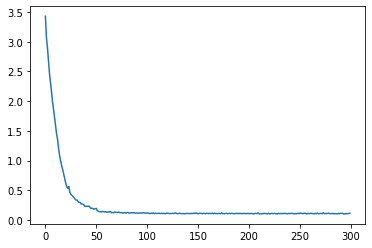

In [5]:
# 训练 LSTM 模型;  ---- 这里的损失函数是计算Sequence最后一个元素的预测数据和真实数据差异
model.train()
epoches = 300
epoch_loss = 0
epoch_loss_list = []

for epoch in range(epoches):
    for step in range(train_batch_count):
        pred = model(train_x[step])
        loss = loss_func(pred[:][-1], train_y[step][:][-1])                # Compare the all sequences' last element in one batch
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=20, norm_type=2)
        optimizer.step()
        
        epoch_loss += loss.data.cpu()
        
    if epoch_loss.item() < 1e-4:
        print('Epoch [{}/{}], Loss: {:.5f}'.format(epoch+1, epoches, loss.item()))
        print("The loss value is reached")
        break

    print("{} of {} epoch loss: {:.4f} with lr: {}".format(epoch, epoches, epoch_loss.item(), optimizer.state_dict()['param_groups'][0]['lr']))
    epoch_loss_list.append(epoch_loss)
    epoch_loss = 0
    
    if (epoch+1) % 50 ==0:
        scheduler.step()
    # print("learning rate: {}".format(optimizer.state_dict()['param_groups'][0]['lr']))
    # for p in optimizer.param_groups:
    #     p['lr'] *= 0.99
    
plt.plot(epoch_loss_list)
plt.show()    

In [6]:
# 保存模型
torch.save(model, 'e:\\Model_LSTM2.pkl')

In [7]:
# 加载模型
model = torch.load('e:\\Model_LSTM2.pkl')

Prediction Loss average:0.000058
Prediction: -0.03 ---- Actual: 0.00


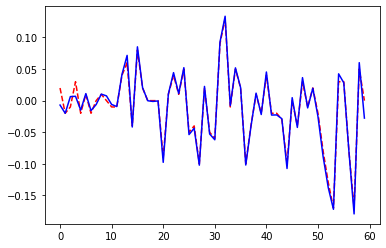

In [9]:
# 用模型预测数据
model.eval()
test_loss = 0

for step in range(test_batch_count):
    pred = model(test_x[step])

    loss = loss_func(pred[:][-1], test_y[step][:][-1])                # Compare the all sequences' last element in one batch
    
    test_loss += loss.cpu()
    
print("Prediction Loss average:{:.6f}".format(test_loss.data/(step+1)))
print("Prediction: {:.2f} ---- Actual: {:.2f}".format(float(pred[-1][-1].data), float(test_y[step][-1][-1].data)))

actual_line = test_y[step][-1].cpu().detach().flatten().numpy()        # Only plot the last sequence of test batch
pred_line   = pred[-1].cpu().detach().flatten().numpy()                # Only plot the last sequence of test batch
plt.plot(actual_line, 'r--')
plt.plot(pred_line, 'b-')
plt.show()
